In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('./owid-covid-data.csv', usecols=['location', 'date', 'total_cases'],
                   parse_dates=True)
data = data[data.location == 'Germany']

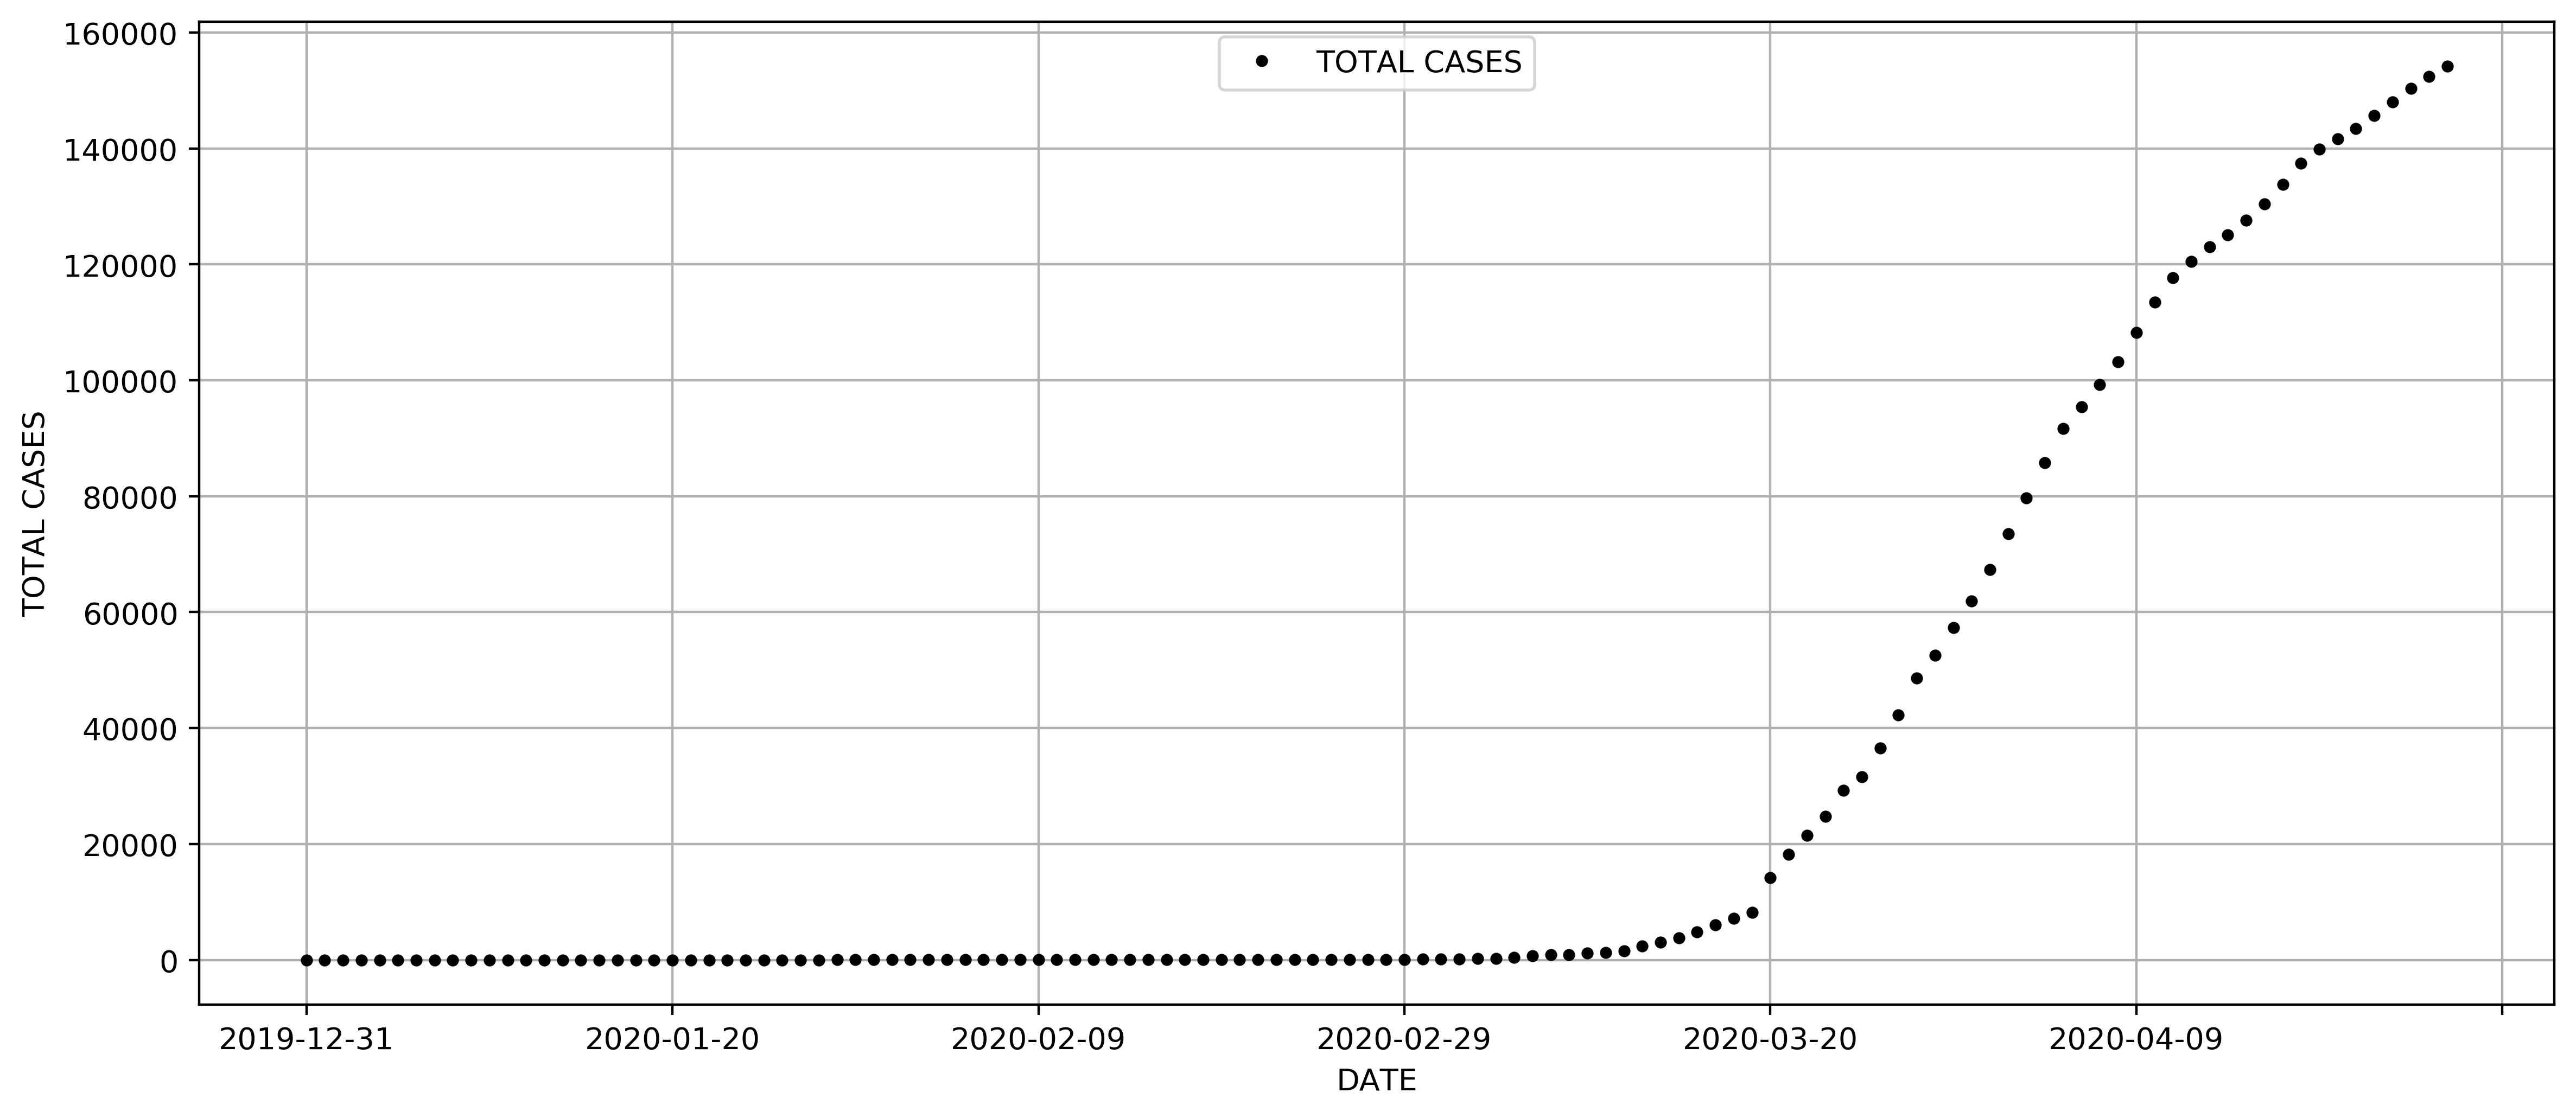

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6), dpi=400)
data.plot(x='date', y='total_cases', ax=axes, logy=False, style='k.')
axes.set_xlabel('DATE')
axes.set_ylabel('TOTAL CASES')
axes.grid()
axes.legend(['TOTAL CASES'], loc='upper center')
plt.show()

Хи = 0.21706406632246159


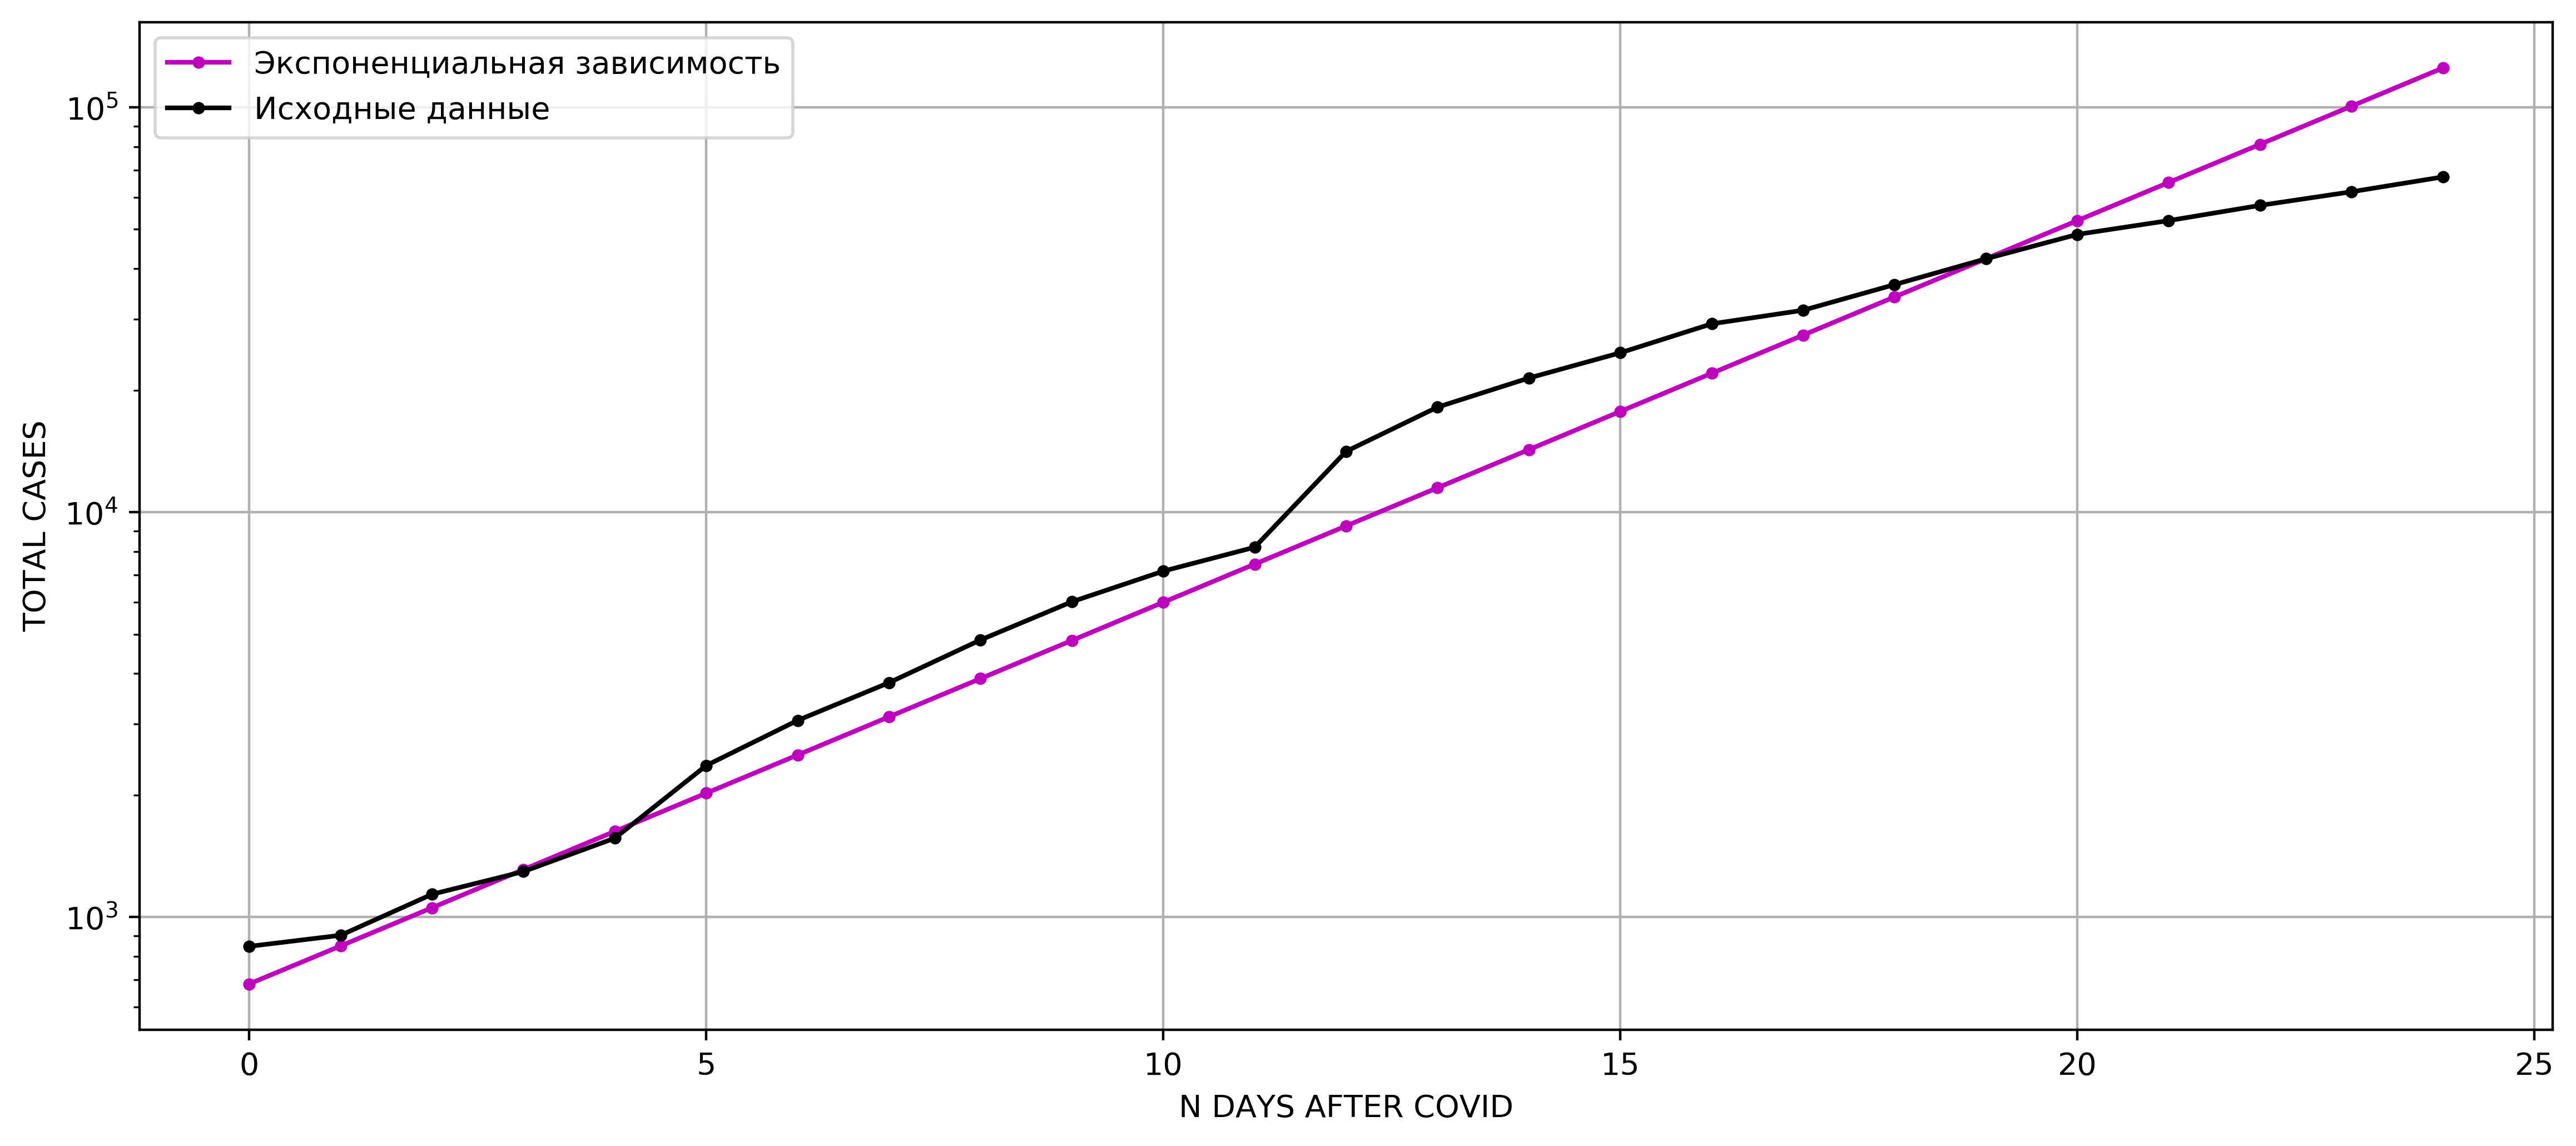

In [ ]:
day_cnt = 25
I0 = 684
true_data = data[data.total_cases > I0].reset_index()
Y = np.log(true_data.total_cases[0:day_cnt] / I0)
X = pd.Series(np.arange(0, Y.size))
chi = (1 / X.T.dot(X)) * X.T.dot(Y)
print("Хи = {}".format(chi))

def exponential(I0, chi, t):
    return I0 * np.exp(chi * t)

aprox_y = exponential(I0, chi, X).astype('int64')

exponential_data = true_data[0:day_cnt]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), dpi=400)
aprox_y.plot(ax=axes, logy=True, style='m.-')
exponential_data.plot(y='total_cases', ax=axes, logy=True, style='k.-')
axes.set_xlabel('N DAYS AFTER COVID')
axes.set_ylabel('TOTAL CASES')
axes.grid()
axes.legend(['Экспоненциальная зависимость', 'Исходные данные'], loc='best')
plt.show()

238515 769


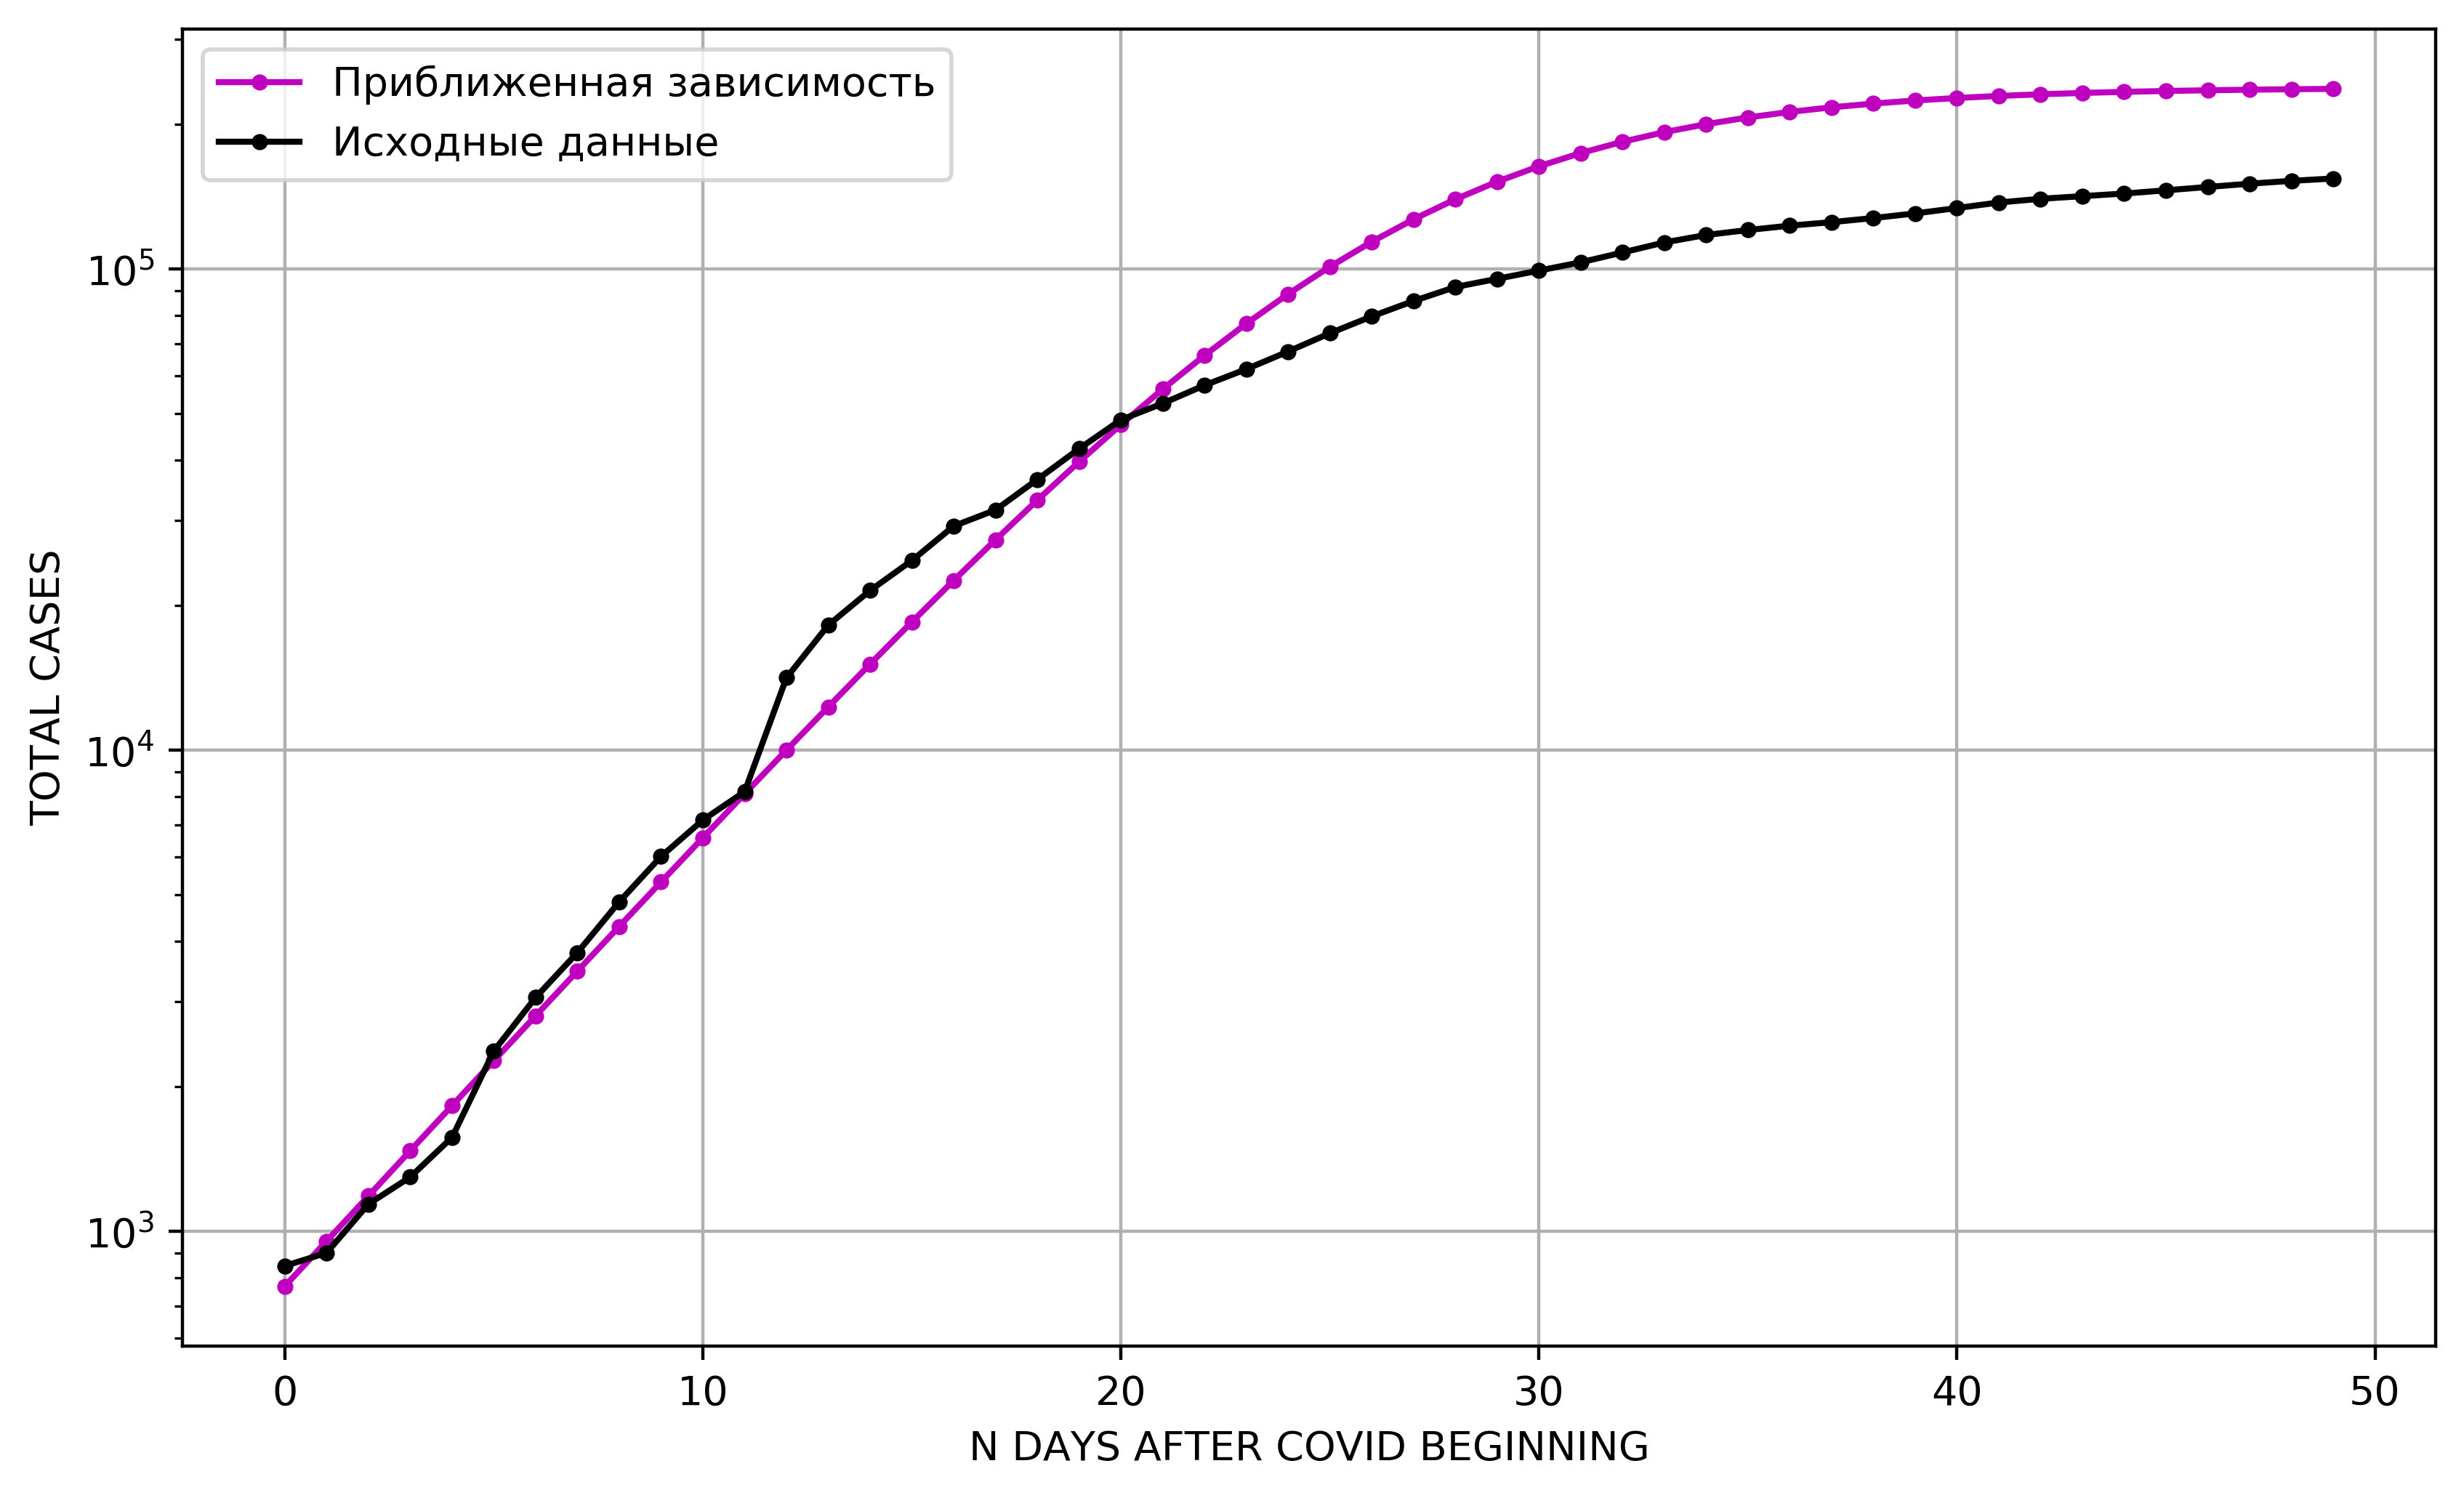

[4.1926023e-06 1.2969439e-03]


In [ ]:
X = np.exp(pd.Series(np.arange(0, true_data.shape[0])) * (-chi))
Y = 1 / true_data.total_cases
X = pd.concat([pd.Series(np.ones(X.shape)), X], axis=1)
A = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
I_inf = int(round(np.abs(1 / A[0])))
I0 = int(round(np.abs(1 / (A[1] + A[0]))))
print(I_inf,I0)

def SIS(I0, I_inf, chi, t):
    return I_inf / (1 + (I_inf / I0 - 1) * np.exp(-chi * t))

days_range = np.arange(0, true_data.shape[0])
X = pd.Series(days_range, index=days_range)
aprox_y = SIS(I0, I_inf, chi, X).astype('int64')

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=400)
aprox_y.plot(ax=axes, logy=True, style='m.-')
true_data.plot(y='total_cases', ax=axes, logy=True, style='k.-')
axes.set_xlabel('N DAYS AFTER COVID BEGINNING')
axes.set_ylabel('TOTAL CASES')
axes.grid()
axes.legend(['Приближенная зависимость', 'Исходные данные'], loc='best')
plt.show()
print(A)

238514.74755006502 760.8588374093439


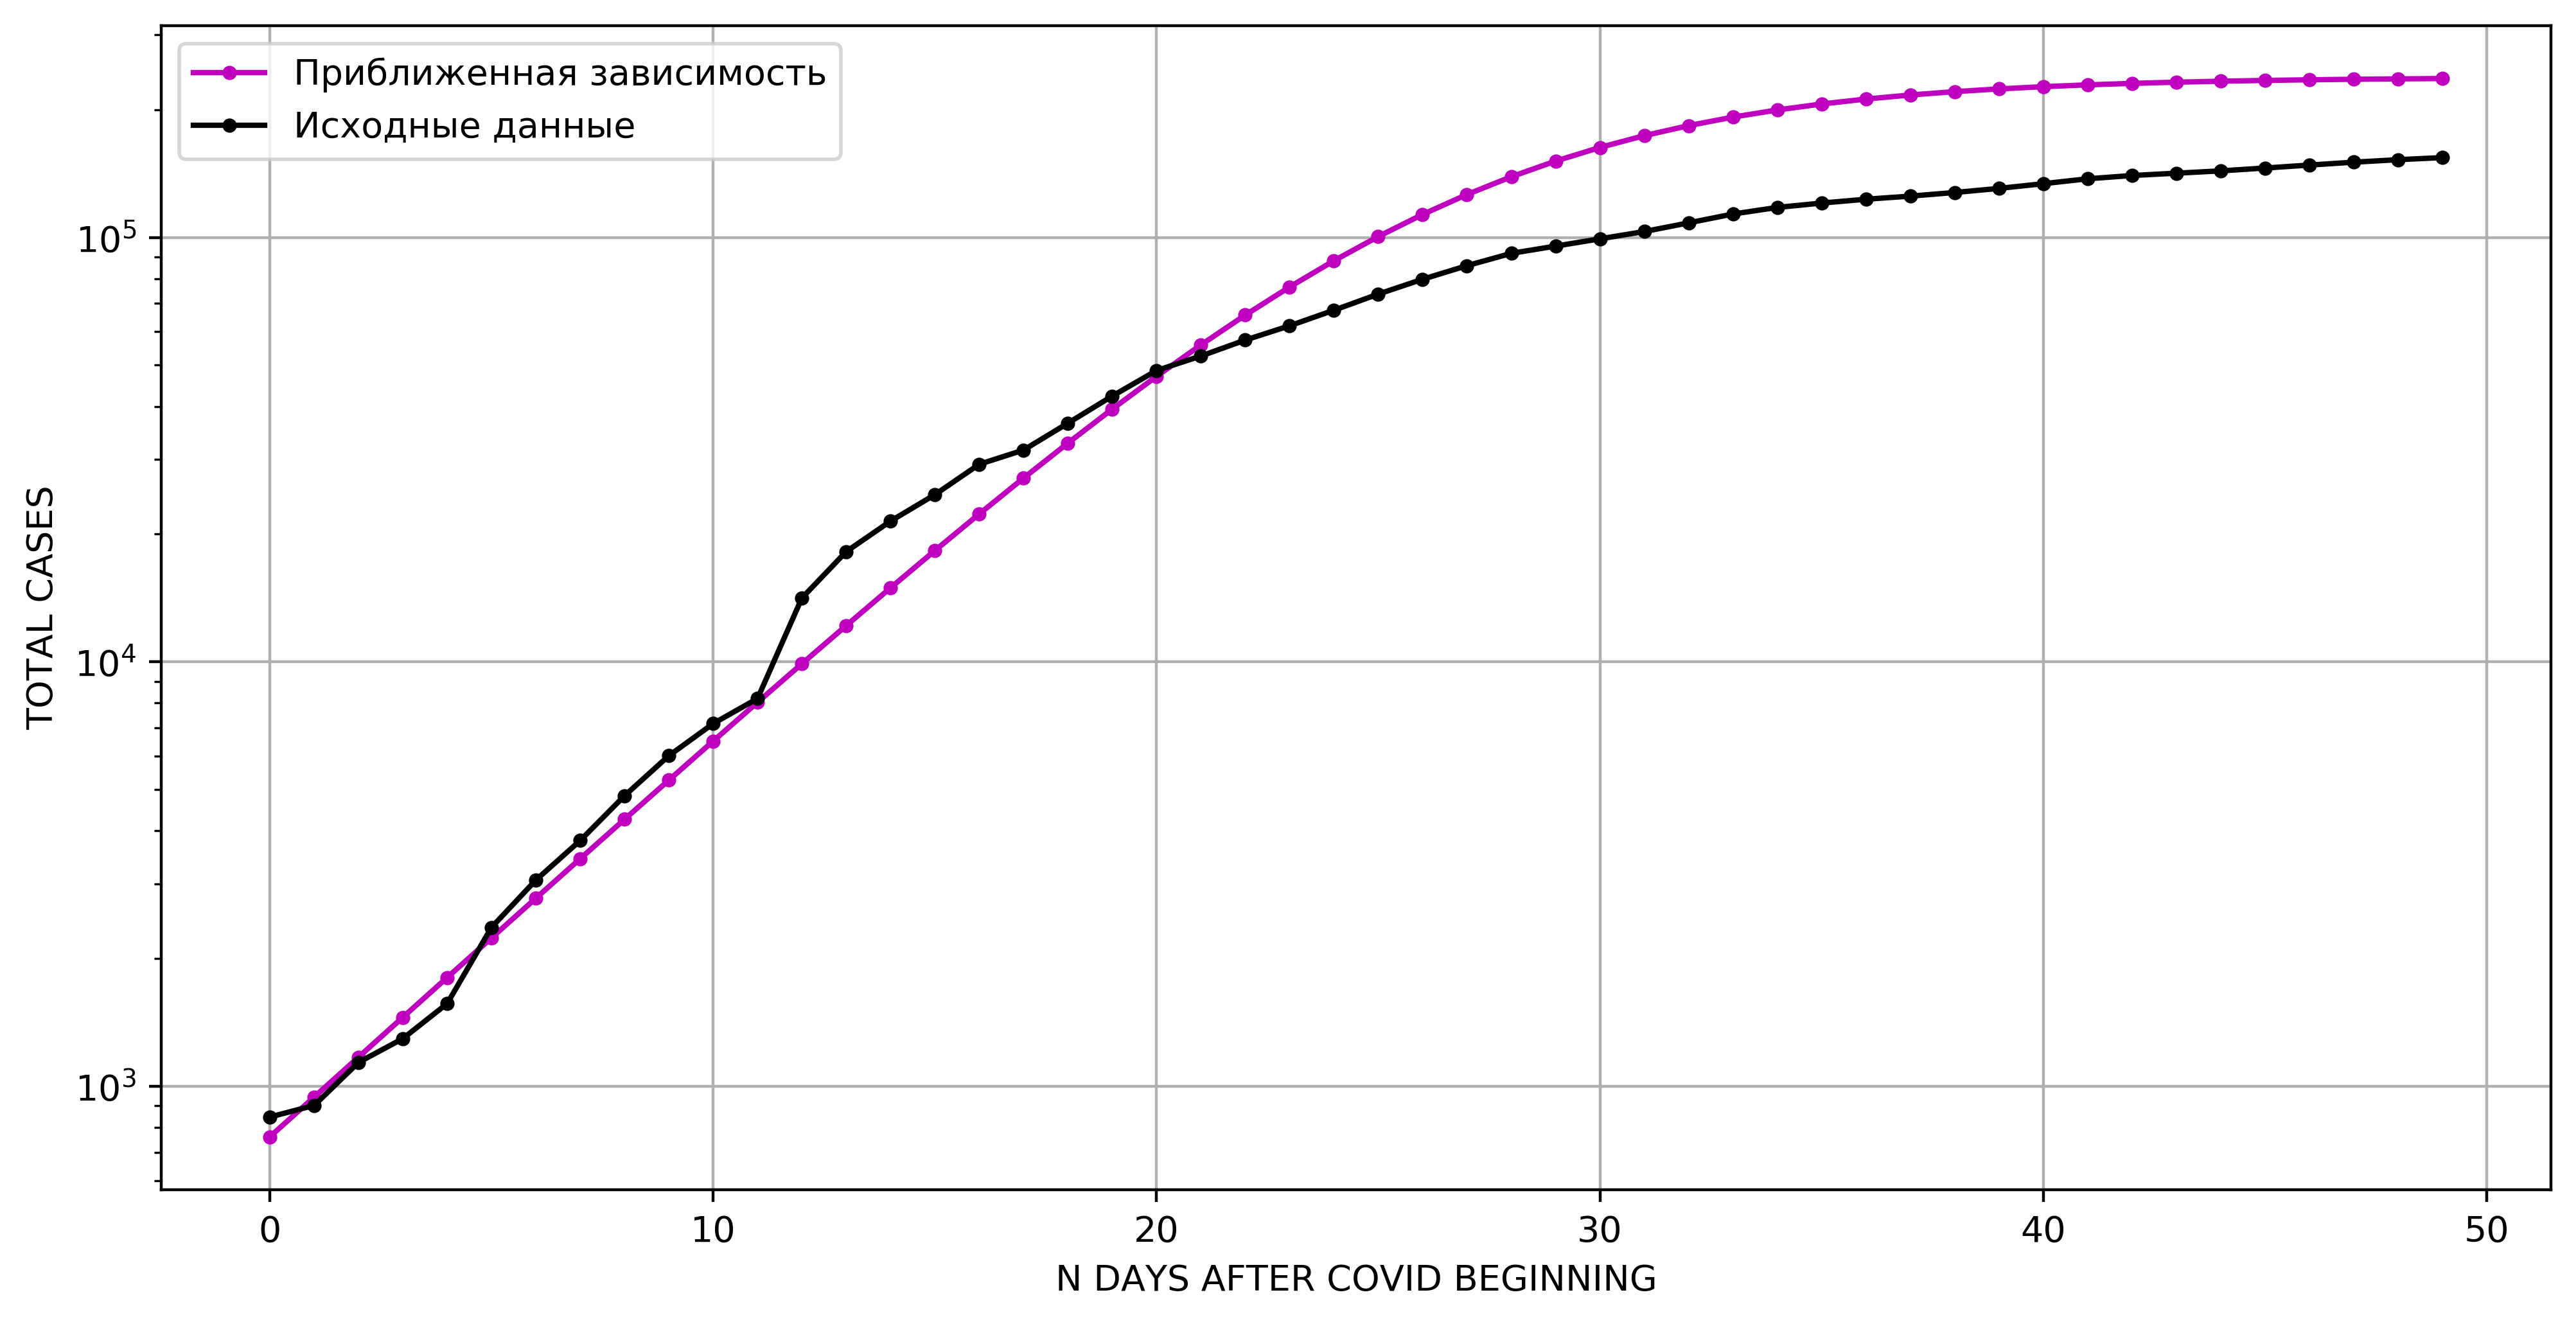

In [ ]:
from scipy.optimize import basinhopping

def error(args):
    I0, I_inf = args
    Y_approx = SIS(I0, I_inf, chi, X).astype('int64')
    Y_real = true_data.total_cases
    return np.sqrt((Y_real - Y_approx).pow(2).sum() / Y.size)

sol = basinhopping(error, [I0, I_inf])

I0_opt, I_inf_opt = sol.x
print(I_inf_opt,I0_opt)
I0_opt, I_inf_opt = int(round(I0_opt)), int(round(I_inf_opt))
aprox_y_opt = SIS(I0_opt, I_inf_opt, chi, X).astype('int64')

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=400)
aprox_y_opt.plot(ax=axes, logy=True, style='m.-')
true_data.plot(y='total_cases', ax=axes, logy=True, style='k.-')
axes.set_xlabel('N DAYS AFTER COVID BEGINNING')
axes.set_ylabel('TOTAL CASES')
axes.grid()
axes.legend(['Приближенная зависимость', 'Исходные данные'], loc='upper left')
plt.show()

In [ ]:
def lebeg_error(Y_real, Y_approx):
    return (Y_real - Y_approx).abs().max()

leb_error = lebeg_error(true_data.total_cases, aprox_y)
print("Погрешность в Лебеговой норме (без оптимизации): {}".format(leb_error))
leb_error = lebeg_error(true_data.total_cases, aprox_y_opt)
print("Погрешность в Лебеговой норме (c оптимизацией): {}".format(leb_error))

def l2_error(Y_real, Y_approx):
    return np.sqrt((Y_real - Y_approx).pow(2).sum() / Y.size)

l2_err = l2_error(true_data.total_cases, aprox_y)
print("Погрешность в L2 норме (без оптимизации): {}".format(l2_err))
l2_err = l2_error(true_data.total_cases, aprox_y_opt)
print("Погрешность в L2 норме (с оптимизацией): {}".format(l2_err))

Погрешность в Лебеговой норме (без оптимизации): 93483
Погрешность в Лебеговой норме (c оптимизацией): 93339
Погрешность в L2 норме (без оптимизации): 56065.491495928225
Погрешность в L2 норме (с оптимизацией): 55904.532000903106


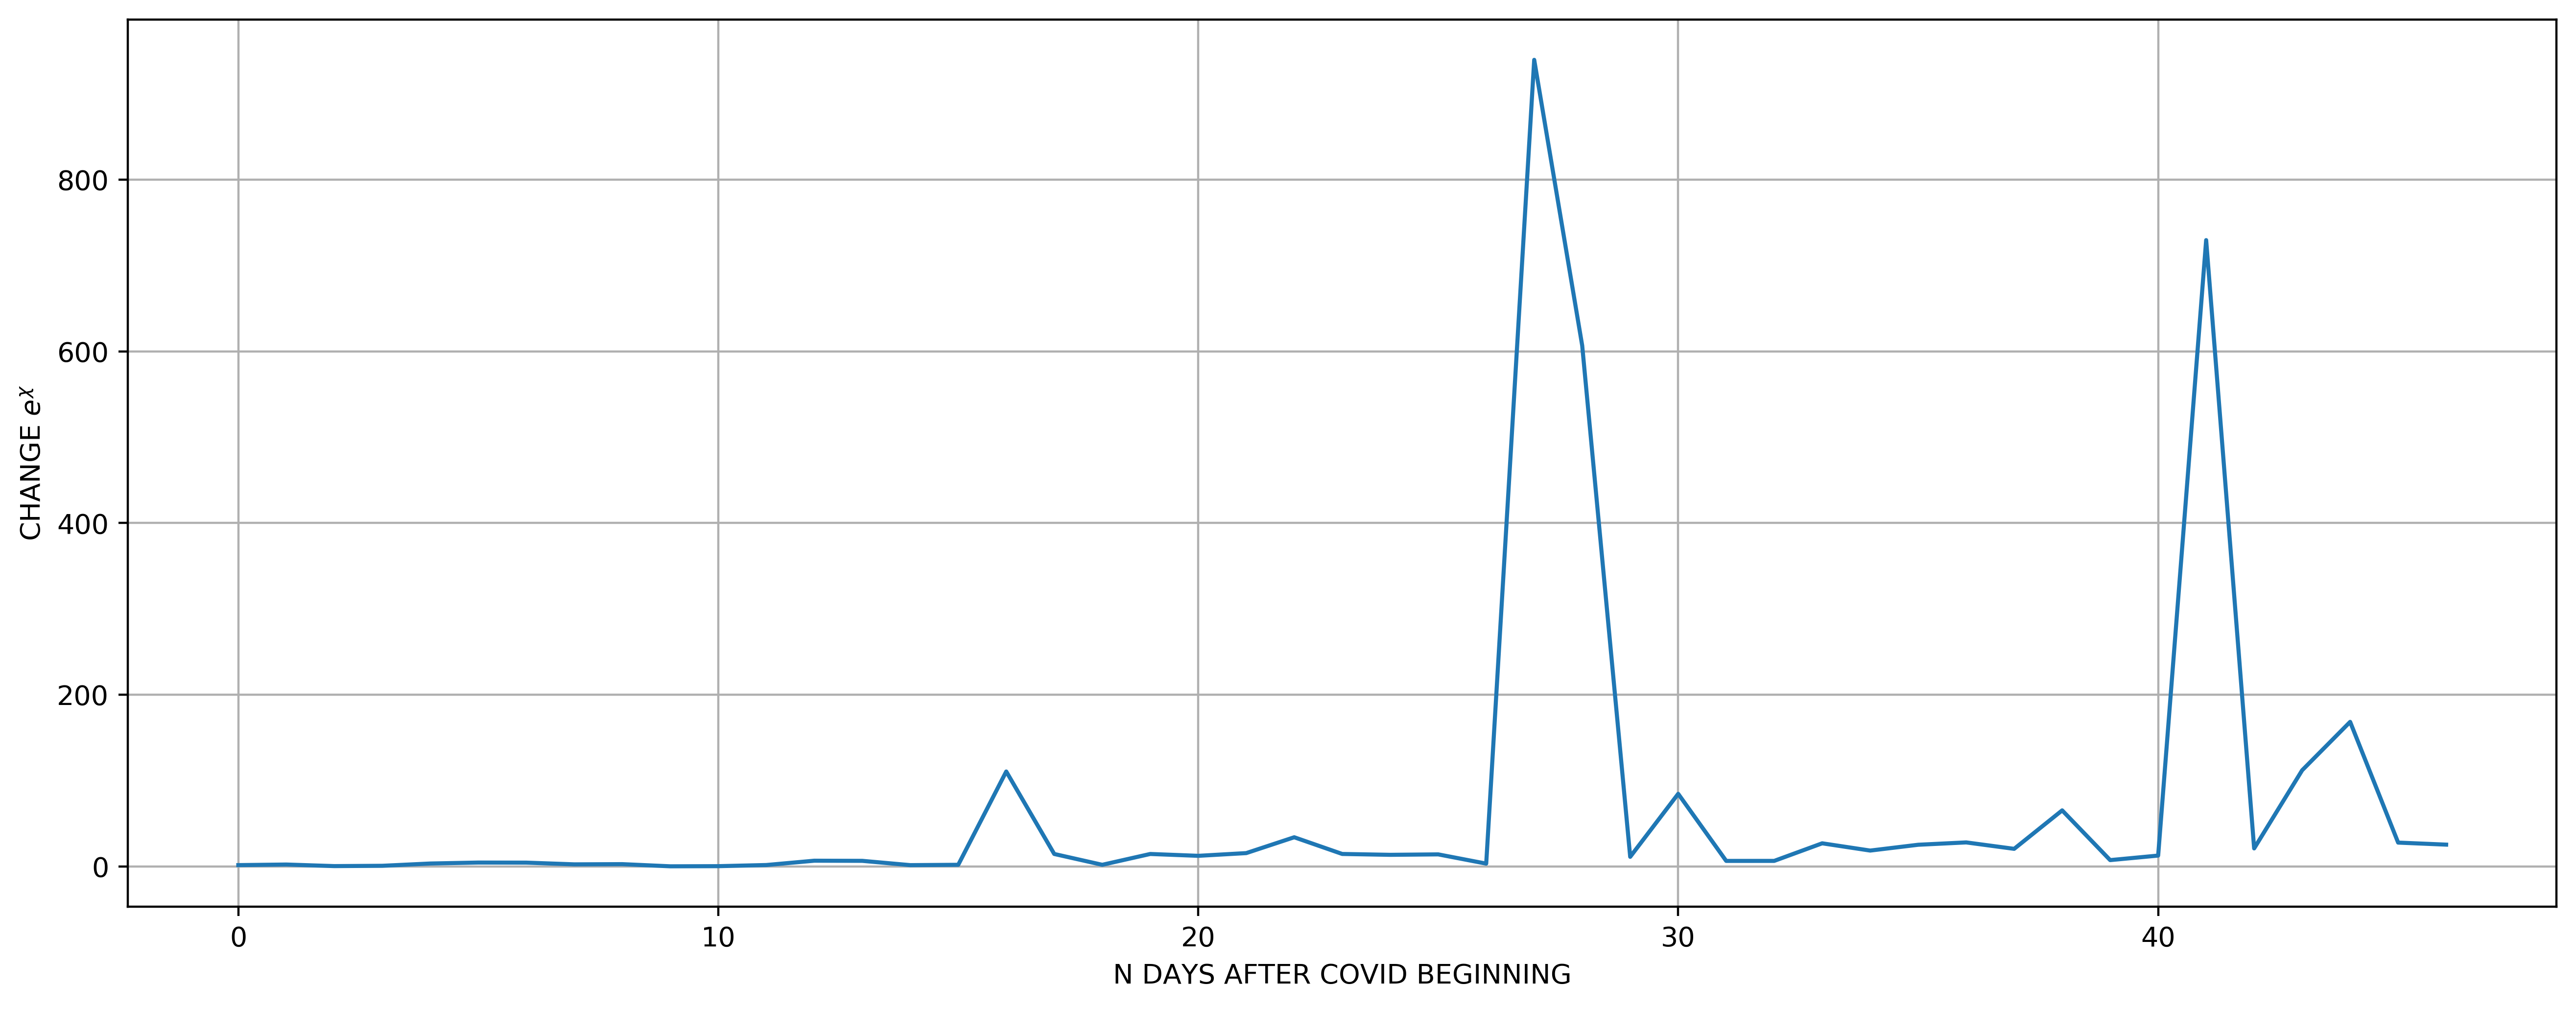

In [ ]:
exp_b_list = []
for i in range(1, true_data.total_cases.size):
    exp_b_list.append(true_data.total_cases[i] / true_data.total_cases[i - 1])

deriv = []
for i in range(1, len(exp_b_list)):
    deriv.append(np.abs(exp_b_list[i] - exp_b_list[i-1]))

otn = []
for i in range(1, len(deriv)):
    otn.append(np.mean(deriv[0:i]) / deriv[i])

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), dpi=400)
axes.set_xlabel('N DAYS AFTER COVID BEGINNING')
axes.set_ylabel('CHANGE $e^{\chi}$')
axes.grid()

plt.plot(range(0, len(otn)), otn)
plt.show()

In [ ]:
from math import ceil
def max_pandemia_days(I0, I_inf, chi):
    return -np.log(0.01 / ((I_inf / I0 - 1) * (1 - 1.01 * np.exp(-chi)))) / chi

max_days = ceil(max_pandemia_days(I0, I_inf, chi))
print("Дней до окончания пандемии: {}".format(max_days))
print("Число заболевших при  t → ∞: {}".format(I_inf))

Дней до окончания пандемии: 40
Число заболевших при  t → ∞: 238515
